In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)


# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


######
# dat = loadtxt('../data/gvmin/gvmin_Halo.txt')
# v_min = dat[0,:]
# gmin_Halo = dat[1:,:]
# gmin_Halo_gf = loadtxt('../data/gvmin/gvmin_Halo_GF.txt',skiprows=1)

# gmin_Saus = loadtxt('../data/gvmin/gvmin_Saus.txt',skiprows=1)
# gmin_Saus_gf = loadtxt('../data/gvmin/gvmin_Saus_GF.txt',skiprows=1)

# gmin_sub = loadtxt('../data/gvmin/gvmin_Shards.txt',skiprows=1)
# gmin_sub_gf = loadtxt('../data/gvmin/gvmin_Shards_GF.txt',skiprows=1)

# eta = 0.2
# gmin0 = (1-eta)*gmin_Halo + eta*gmin_Saus
# gmin0_gf = (1-eta)*gmin_Halo_gf + eta*gmin_Saus_gf

# nv = size(v_min)
# nt = shape(gmin0)[0]
# t = linspace(0,365-365/(1.0*nt),nt)
#######


# v_mins
n = 300
v = linspace(0.01,750.0,n)

# Times
ndays = 20
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate everything
gmin_Iso = zeros(shape=(ndays,n))
gmin_Iso_gf = zeros(shape=(ndays,n))
gmin_Saus = zeros(shape=(ndays,n))
gmin_Saus_gf = zeros(shape=(ndays,n))
gmin_sub = zeros(shape=(ndays,n))
gmin_sub_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    gmin_Iso[i,:] = gvmin_Triaxial(v,days[i],sig_iso)
    gmin_Iso_gf[i,:] = gvmin_Triaxial(v,days[i],sig_iso,GravFocus=True)
    
    gmin_Saus[i,:] = gvmin_Triaxial(v,days[i],sig_beta)
    gmin_Saus_gf[i,:] = gvmin_Triaxial(v,days[i],sig_beta,GravFocus=True)

    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        gmin_sub[i,:] += weights[isub]*gvmin_Triaxial(v,days[i],sig_s,v_shift=v_s)
        gmin_sub_gf[i,:] += weights[isub]*gvmin_Triaxial(v,days[i],sig_s,v_shift=v_s,GravFocus=True)
    
    
    print('day = ',i,'of',ndays,sum(gmin_sub[i,:]),sum(gmin_sub_gf[i,:]))



day =  0 of 20 0.3992846174303047 0.4017384719538995
day =  1 of 20 0.39929352493949205 0.4029423099256109
day =  2 of 20 0.399277718899841 0.40565940676307577
day =  3 of 20 0.39925814368278345 0.4071874435785472
day =  4 of 20 0.3992454341073973 0.4076112984952141
day =  5 of 20 0.39922952871253425 0.4042625751321607
day =  6 of 20 0.39922105930361224 0.40182114083774406
day =  7 of 20 0.3992460639883026 0.40072283309106277
day =  8 of 20 0.3992653783573066 0.4020310392137622
day =  9 of 20 0.3992679503761296 0.40143514027886884
day =  10 of 20 0.3992703292978988 0.4013941764901219
day =  11 of 20 0.39927733685212163 0.40070889922208686
day =  12 of 20 0.39928455089047016 0.40006552100357295
day =  13 of 20 0.39928586110739467 0.3998649331874009
day =  14 of 20 0.3992918069984331 0.4004905120196864
day =  15 of 20 0.3993212576372217 0.40003715707997517
day =  16 of 20 0.39933346474143 0.4004009801221529
day =  17 of 20 0.3993151273170707 0.4009848231151513
day =  18 of 20 0.399286873

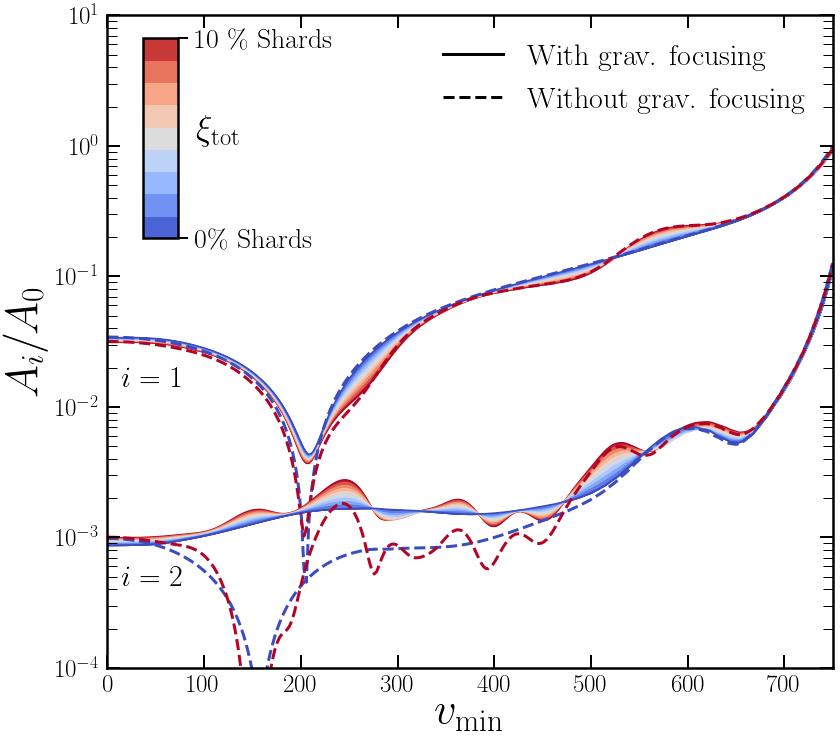

In [12]:
from PlotFuncs import *

from numpy.fft import fft

import cmocean

nt = size(days)
zorder =0

# Get all fourier components
def FourierComponents(gmin,nc):
    nv = shape(gmin)[1]
    a0 = zeros(shape=nv)
    b = zeros(shape=(nc,nv))
    a = zeros(shape=(nc,nv))
    for i in range(0,nv):
        y = gmin[:,i]
        yfft = fft(y)/(1.0*nt)
        yfft = yfft[0:(nc+1)]
        a0[i] = real(yfft[0])
        a[:,i] = 2*real(yfft[1:])
        b[:,i] = -2*imag(yfft[1:])
    return a0,a,b
nc = 5



n_xi = 10
xi_max = 0.1
xi_vals = linspace(0.0,xi_max,n_xi)

xlab = r"$v_{\rm min}$"

fig,ax1 = MySquarePlot(xlab,r'$A_i/A_0$')

eta = 0.2
col = (cm.coolwarm(linspace(0,1,n_xi)))

for ic in [0,1]:

    # With GF
    zorder=0
    A0_0,a_1,b_1 = FourierComponents(((1-eta)*gmin_Iso_gf+eta*gmin_Saus_gf)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    for j in range(0,n_xi):
        i = n_xi-1-j
        xi = xi_vals[i]
        A0,a,b = FourierComponents(((1-xi-eta)*gmin_Iso_gf+eta*gmin_Saus_gf + xi*gmin_sub_gf)/v,nc)
        A1 = sqrt(a[ic,:]**2.0+b[ic,:]**2.0)

        ax1.fill_between(v,A1/A0,y2=A1_0/A0_0,color=col[i,:],alpha=0.9,zorder=zorder)
        ax1.plot(v,A1/A0,'-',color=col[i,:],zorder=zorder)

    #ax1.plot(v,A1_0/A0_0,'k-',lw=3,zorder=zorder)

    # without GF
    A0_0,a_1,b_1 = FourierComponents(((1-eta)*gmin_Iso+eta*gmin_Saus)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    ax1.plot(v,A1_0/A0_0,'--',color=col[0,:],lw=3,zorder=zorder)

    A0_0,a_1,b_1 = FourierComponents(((1-xi_max-eta)*gmin_Iso+eta*gmin_Saus + xi_max*gmin_sub)/v,nc) 
    A1_0 = sqrt(a_1[ic,:]**2.0+b_1[ic,:]**2.0)
    ax1.plot(v,A1_0/A0_0,'--',color=col[-1,:],lw=3,zorder=zorder)


plt.plot([-1,-1],[-2,-1],'k-',lw=3,label='With grav. focusing')
plt.plot([-1,-1],[-2,-1],'k--',lw=3,label='Without grav. focusing')
plt.legend(loc='upper right',fontsize=30,frameon=False)


plt.yscale('log')
plt.ylim([1e-4,1e1])
ax1.set_xlim(left=0.0,right=750.0)


# # Custom colorbar
plt.sca(ax1)
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax1, width="5%", height="50%", bbox_to_anchor=[-500, 350, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28)
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.22,0.73,r'$\xi_{\rm tot}$',fontsize=35,color='k')

plt.gcf().text(0.14,0.45,r'$i=1$',fontsize=30,rotation=0)
plt.gcf().text(0.14,0.22,r'$i=2$',fontsize=30,rotation=0)

# Save figure
plt.show()
pltname = 'Shards_FourierA_gmin'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')


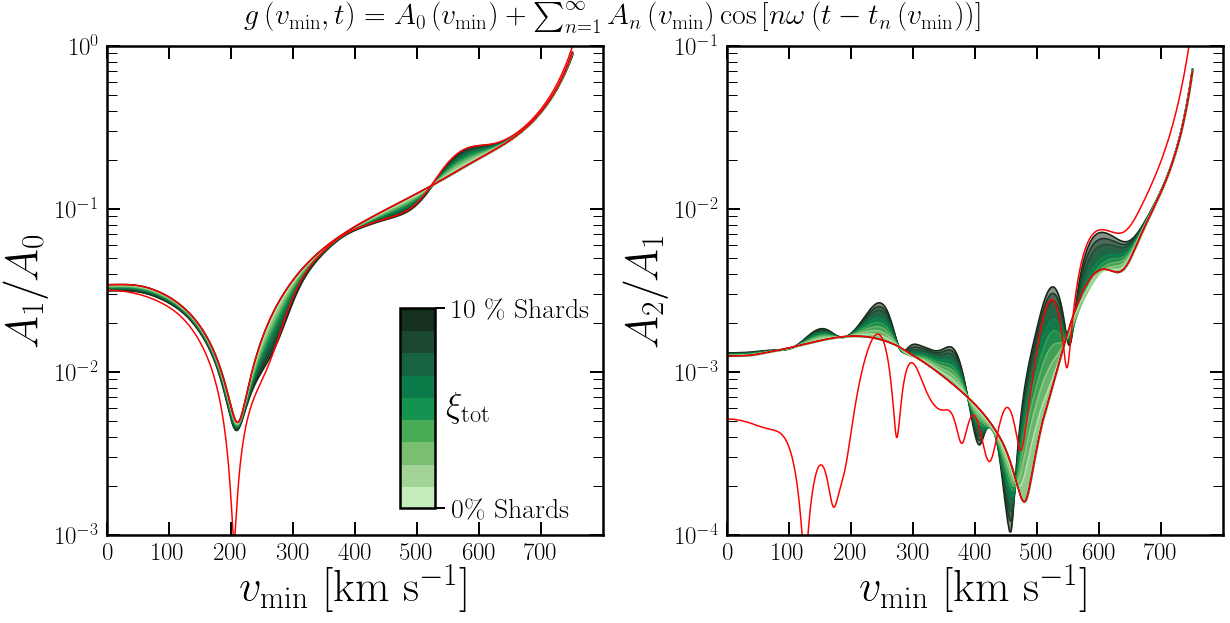

In [53]:
nc = 4
a0,a,b = FourierComponents(gmin0_gf,nc) 
a0_gf,a_gf,b_gf = FourierComponents(0.8*gmin0_gf+0.2*gmin_sub_gf,nc)


fig,ax1,ax2 = MyDoublePlot(r'$v_{\rm min}$ [km s$^{-1}$]',r'$A_1/A_0$',r'$v_{\rm min}$ [km s$^{-1}$]',r'$A_2/A_1$',size_y=9,wspace=0.25)

n_xi = 10
xi_max = 0.1
xi_vals = flipud(linspace(0.0,xi_max,n_xi))



j = 0
zorder=0
col = (cmocean.cm.algae_r(linspace(0,1,n_xi)))
A0_0,a_1,b_1 = FourierComponents(gmin0_gf,nc) 
A1_0 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2_0 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
for i in range(0,n_xi):
    xi = xi_vals[i]
    A0,a,b = FourierComponents((1-xi)*gmin0_gf+xi*gmin_sub_gf,nc)
    A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
    A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
    
    ax1.fill_between(v_min,A1/A0,y2=A1_0/A0_0,color=col[i,:],alpha=0.5,zorder=zorder)
    ax1.plot(v_min,A1/A0,'-',color=col[i,:],zorder=zorder)
    
    ax2.fill_between(v_min,A2/A0,y2=A2_0/A0_0,color=col[i,:],alpha=0.5,zorder=zorder)
    ax2.plot(v_min,A2/A0,'-',color=col[i,:],zorder=zorder)
ax1.plot(v_min,A1_0/A0_0,'k-',lw=1.5,zorder=zorder)
ax2.plot(v_min,A2_0/A0_0,'k-',lw=1.5,zorder=zorder)




    
# Without GF
ax1.plot(v_min,A1_0/A0_0,'r-',lw=1.5,zorder=zorder+1)
ax2.plot(v_min,A2_0/A0_0,'r-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents((1-xi_max)*gmin0+xi_max*gmin_sub,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
ax1.plot(v_min,A1/A0,'r-',lw=1.5,zorder=zorder+1)
ax2.plot(v_min,A2/A0,'r-',lw=1.5,zorder=zorder+1)




ax1.set_yscale('log')
ax1.set_ylim([1e-3,1e0])
ax1.set_xlim([0,800])

ax2.set_yscale('log')
ax2.set_ylim([1e-4,1e-1])
ax2.set_xlim([0,800])

ax1.set_xticks(arange(0,800,100))
ax2.set_xticks(arange(0,800,100))


# # Custom colorbar
plt.sca(ax2)
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax2, width="5%", height="50%", bbox_to_anchor=[-180, -80, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmocean.cm.algae, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28)
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.36,0.3,r'$\xi_{\rm tot}$',fontsize=35,color='k')


eq = r'$g\left(v_{\min }, t\right)=A_{0}\left(v_{\min }\right)+\sum_{n=1}^{\infty} A_{n}\left(v_{\min }\right) \cos \left[n \omega\left(t-t_{n}\left(v_{\min }\right)\right)\right]$'
plt.gcf().text(0.22,0.9,eq,fontsize=30)

# Save figure
plt.show()
pltname = 'Shards_FourierA'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')


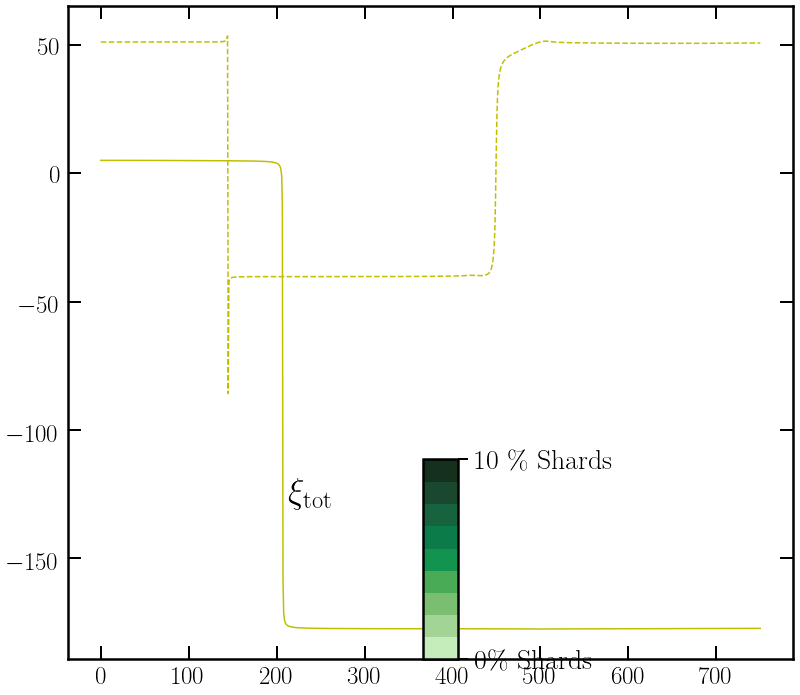

In [87]:
w = 2*pi/1.0
t0 = 0.18
def ti(a,b,n):
    ai = a[n-1,:]
    bi = b[n-1,:]
    nwt = n*w*t0
    ti = -(1.0/(n*w))*arctan2((ai*cos(nwt)+bi*sin(nwt)),(ai*sin(nwt)-bi*cos(nwt)))
    return ti 

fig,ax1 = MySquarePlot()

A0,a,b = FourierComponents(gmin_Halo,5)
plt.plot(v_min,365*(ti(a,b,2)),'y--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,365*(ti(a,b,1)),'y-',lw=1.5,zorder=zorder+1)

#A0,a,b = FourierComponents(gmin_Saus,2)
#plt.plot(v_min,365*(-ti(a,b,2)),'k--',lw=1.5,zorder=zorder+1)
#plt.plot(v_min,365*(-ti(a,b,1)),'k-',lw=1.5,zorder=zorder+1)


#plt.yticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
#           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
#           rotation=0)

#plt.ylim([130.0,365.0])
#plt.xlim([0.0,750.0])
ax1.set_xticks(arange(0,800,100))



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax1, width="5%", height="50%", bbox_to_anchor=[-180, -80, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmocean.cm.algae, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28)
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.36,0.3,r'$\xi_{\rm tot}$',fontsize=35,color='k')



# Save figure
plt.show()
pltname = 'Shards_Fouriert'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')


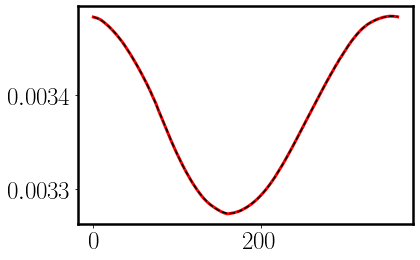

In [77]:
# Checking it works

th = linspace(0,2*pi-2*pi/nt,nt)
nc = 10
a = zeros(shape=(nc,1))
b = zeros(shape=(nc,1))


y = 0.1*gmin_sub_gf[:,0]+0.9*gmin0_gf[:,0]
yfft = fft(y)/(1.0*nt)
yfft = yfft[0:(nc+1)]
a0 = real(yfft[0])
a[:,0] = 2*real(yfft[1:])
b[:,0] = -2*imag(yfft[1:])


def FourierReconstruct(a0,a,b,nt):
    th = linspace(0,2*pi-2*pi/nt,nt)
    nc = size(a)
    n = zeros(shape=(nc,1))
    n[:,0] = arange(1,nc+1) 
    a = repeat(a, nt, axis=1)
    b = repeat(b, nt, axis=1)
    n = repeat(n, nt, axis=1)
    y_rec = a0 + sum(a*cos(n*th)+b*sin(n*th),axis=0)
    return y_rec
    
plt.plot(t,y,'r-',lw=3)
plt.plot(t,FourierReconstruct(a0,a,b,nt),'k--')

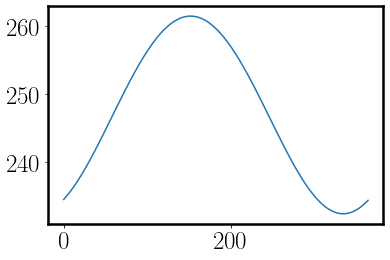

In [82]:
v_e = zeros(shape=nt)
for i in range(0,nt):
    v_e[i] = sqrt(sum(LabVelocitySimple(t[i])**2.0))
plt.plot(t,v_e)